In [ ]:
!pip install fbprophet

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
df = pd.read_csv("/content/nyc_data.csv")

In [4]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


We see the data is in half n hour basis. First thing we do is convert timestamp column to datatime datatype in pandas and then convert the data into hourly basis for simplicity and reducing number of data samples

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [7]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [8]:
df = df.set_index("timestamp").resample("H").mean()

In [9]:
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


In [10]:
fig = px.line(df.reset_index(), x = "timestamp", y = "value", title="NYC Taxi Demand")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [11]:
from fbprophet import Prophet

FBprophet expects datatime colummn name to be ds and value column name to y.

In [12]:
taxi_df = df.reset_index()[["timestamp","value"]].rename({"timestamp":"ds", "value":"y"}, axis="columns")

In [13]:
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [14]:
train = taxi_df[(taxi_df["ds"]>="2014-07-01") & (taxi_df["ds"] <= "2015-01-27")]
test = taxi_df[(taxi_df["ds"]>"2015-01-27")]

In [15]:
train.shape

(5041, 2)

In [16]:
test.shape

(119, 2)

In [17]:
m = Prophet(changepoint_range=0.95) # confidence interval default is 0.8

In [18]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Our data is just for six months, thats why we see above warning disabling yearly seasonality. Next we create dataframe with dates for test predictions

In [19]:
future=m.make_future_dataframe(periods=119, freq="H")
future.tail()

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [20]:
forecast=m.predict(future)
forecast[["ds","yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19104.866796,28514.285844
5156,2015-01-31 20:00:00,24342.584334,19461.482608,29978.482307
5157,2015-01-31 21:00:00,23219.297735,18246.904515,27927.043165
5158,2015-01-31 22:00:00,21027.355314,16219.144739,25455.274075
5159,2015-01-31 23:00:00,18500.216845,13786.524407,23416.454242


In [21]:
results = pd.concat([taxi_df.set_index("ds")["y"], forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]], axis=1)

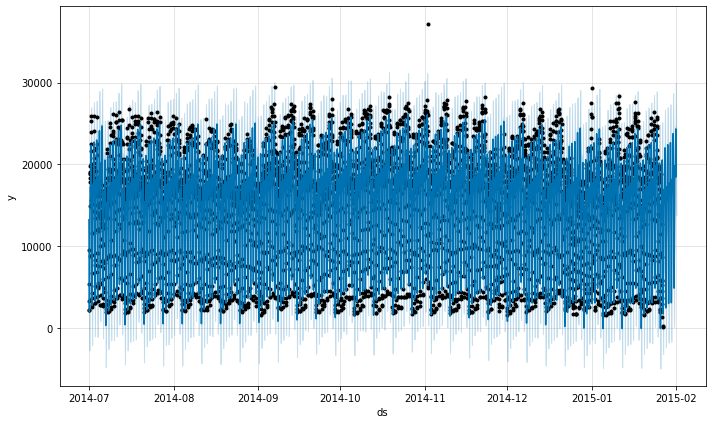

In [22]:
fig1=m.plot(forecast)

The dark blue is yhat prediction, The black is actual y value and the light blue is yhat upper and lower confidence interval. Now lets look at pattterns or trend in data.

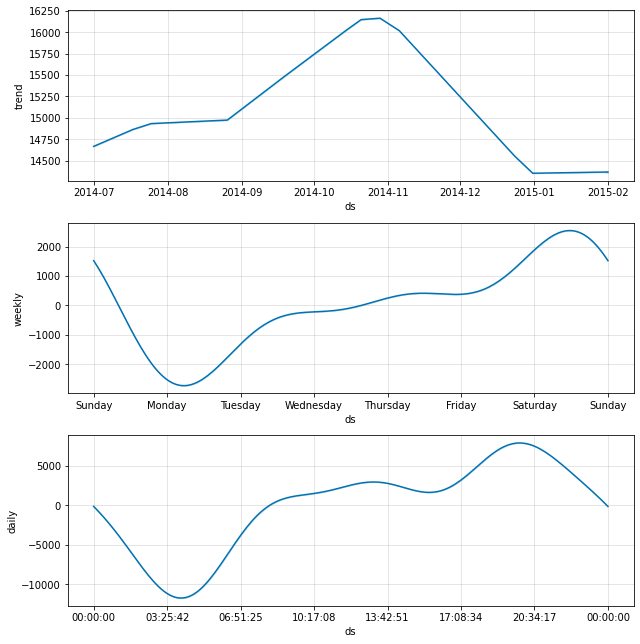

In [23]:
comp=m.plot_components(forecast)

In [24]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8610.642145,18130.896691
2014-07-01 01:00:00,5433.0,10232.486172,5020.151986,14842.463287
2014-07-01 02:00:00,3346.5,6669.099458,1930.195330,11710.849825
2014-07-01 03:00:00,2216.5,3448.054270,-1248.360186,8364.237531
2014-07-01 04:00:00,2189.5,2017.409931,-2743.356650,6831.125629
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19104.866796,28514.285844
2015-01-31 20:00:00,24138.0,24342.584334,19461.482608,29978.482307
2015-01-31 21:00:00,24194.5,23219.297735,18246.904515,27927.043165


In [25]:
results["error"] = results["y"] - results["yhat"]

In [26]:
results["uncertanity"] = results["yhat_upper"] - results["yhat_lower"]

In [27]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertanity
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8610.642145,18130.896691,-3755.232792,9520.254546
2014-07-01 01:00:00,5433.0,10232.486172,5020.151986,14842.463287,-4799.486172,9822.311301
2014-07-01 02:00:00,3346.5,6669.099458,1930.195330,11710.849825,-3322.599458,9780.654495
2014-07-01 03:00:00,2216.5,3448.054270,-1248.360186,8364.237531,-1231.554270,9612.597718
2014-07-01 04:00:00,2189.5,2017.409931,-2743.356650,6831.125629,172.090069,9574.482279
...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19104.866796,28514.285844,4509.970787,9409.419048
2015-01-31 20:00:00,24138.0,24342.584334,19461.482608,29978.482307,-204.584334,10516.999699
2015-01-31 21:00:00,24194.5,23219.297735,18246.904515,27927.043165,975.202265,9680.138650


In [28]:
results[results["error"].abs() > 1.5*results["uncertanity"]]

,y,yhat,yhat_lower,yhat_upper,error,uncertanity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9624.900459,19012.239050,22985.607130,9387.338591
2015-01-01 01:00:00,29292.0,11405.545567,6796.367904,16015.408728,17886.454433,9219.040823
2015-01-01 02:00:00,25753.5,7770.054639,3151.639725,12330.292770,17983.445361,9178.653045
2015-01-01 03:00:00,22067.0,4478.895177,46.201780,9309.808398,17588.104823,9263.606618
2015-01-26 19:00:00,4565.5,19771.308307,15064.408619,24749.191663,-15205.808307,9684.783043
2015-01-26 20:00:00,3630.5,20546.581743,15912.635544,25142.888833,-16916.081743,9230.253289
2015-01-26 21:00:00,2907.0,19647.710004,14637.561351,24436.977832,-16740.710004,9799.416481
2015-01-26 22:00:00,1324.5,17691.969234,12854.944077,22688.740155,-16367.469234,9833.796078
2015-01-26 23:00:00,243.0,15411.348672,10476.499974,20399.114591,-15168.348672,9922.614617


**2014-11-02 01:00:00** there was a marathon so sudden increase in demand for taxi as people came from different cities to participate.

**2015-01-01 01:00:00, 2015-01-01 02:00:00, 2015-01-01 03:00:00** New year we have high demand and the hourly trend is also completely diffrent.

**2015-01-26 21:00:00** was snowstorm and city was closed


In [29]:
results["anomaly"] = results.apply(lambda x: "Yes" if(np.abs(x["error"]) > 1.5*x["uncertanity"]) else "No", axis=1)

In [30]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertanity,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8610.642145,18130.896691,-3755.232792,9520.254546,No
2014-07-01 01:00:00,5433.0,10232.486172,5020.151986,14842.463287,-4799.486172,9822.311301,No
2014-07-01 02:00:00,3346.5,6669.099458,1930.195330,11710.849825,-3322.599458,9780.654495,No
2014-07-01 03:00:00,2216.5,3448.054270,-1248.360186,8364.237531,-1231.554270,9612.597718,No
2014-07-01 04:00:00,2189.5,2017.409931,-2743.356650,6831.125629,172.090069,9574.482279,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19104.866796,28514.285844,4509.970787,9409.419048,No
2015-01-31 20:00:00,24138.0,24342.584334,19461.482608,29978.482307,-204.584334,10516.999699,No
2015-01-31 21:00:00,24194.5,23219.297735,18246.904515,27927.043165,975.202265,9680.138650,No


In [31]:
fig = px.scatter(results.reset_index(), x = "ds", y = "y", color = "anomaly", title="NYC Taxi Demand")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

**Nov 2** looks like complete outlier. But **Dec 31, Jan 26** looks like inlier but they are anaomaly due to variation in hourly seasonal trends.